In [3]:
!pip3 install gower


## Agglomerative Hierarchy Algorithm Implementation

In [1]:
# Add Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import heapq
from scipy.spatial.distance import euclidean
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering as SklearnAgglomerative
from scipy.spatial.distance import euclidean
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score
)
from itertools import product

import gower  # make sure this package is installed



In [2]:
dataset_path = "./../datasets"

iris_dataset_path = dataset_path + "/iris.csv"                                         
ai_global_index_path = dataset_path + "/AI_index_db.csv"
global_earthquake_data_path = dataset_path + "/earthquakes.csv"

datasets = {
    "iris": pd.read_csv(iris_dataset_path),
    "ai_global_index": pd.read_csv(ai_global_index_path),
    "global_earthquake": pd.read_csv(global_earthquake_data_path)
}


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
iris_df = pd.read_csv(iris_dataset_path)
ai_global_index_df = pd.read_csv(ai_global_index_path)
global_earthquake_data_df = pd.read_csv(global_earthquake_data_path)

### Agglomerative Algorithm Implementation (Based on our Algorithm - see report/Part-1.pdf)

In [5]:
class Cluster:
    def __init__(self, points, id, indices=None):
        self.points = np.array(points)
        self.id = id
        self.indices = indices if indices is not None else list(range(len(points)))

    def merge(self, other_cluster):
        merged_points = np.vstack([self.points, other_cluster.points])
        merged_indices = self.indices + other_cluster.indices
        return Cluster(merged_points, self.id, merged_indices)

    def points_idx(self):
        return self.indices



def compute_distance(cluster1, cluster2, linkage='single'):
    if linkage == 'single':
        return min(euclidean(p1, p2) for p1 in cluster1.points for p2 in cluster2.points)
    elif linkage == 'complete':
        return max(euclidean(p1, p2) for p1 in cluster1.points for p2 in cluster2.points)
    elif linkage == 'average':
        distances = [euclidean(p1, p2) for p1 in cluster1.points for p2 in cluster2.points]
        return np.mean(distances)
    else:
        raise ValueError(f"Invalid linkage method: {linkage}")


def hac_custom(data, k, linkage='single', precomputed_dist_matrix=None):
    n = len(data)
    clusters = [Cluster([point], i, [i]) for i, point in enumerate(data)]

    cluster_ids = [cluster.id for cluster in clusters]

    # Use precomputed distance matrix if provided
    if precomputed_dist_matrix is not None:
        dist_matrix = precomputed_dist_matrix.copy()
    else:
        dist_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i + 1, n):
                dist_matrix[i, j] = compute_distance(clusters[i], clusters[j], linkage)
                dist_matrix[j, i] = dist_matrix[i, j]

    # Initialize heap with distances
    heap = []
    for i in range(n):
        for j in range(i + 1, n):
            heapq.heappush(heap, (dist_matrix[i, j], i, j))

    while len(clusters) > k:
        while True:
            min_distance, i, j = heapq.heappop(heap)
            if i in cluster_ids and j in cluster_ids:
                break

        cluster1 = clusters[cluster_ids.index(i)]
        cluster2 = clusters[cluster_ids.index(j)]
        new_cluster = cluster1.merge(cluster2)
        new_cluster_id = new_cluster.id

        # Update clusters
        clusters = [c for c in clusters if c.id not in (i, j)]
        clusters.append(new_cluster)
        cluster_ids = [c.id for c in clusters]

        # Update distances involving the new cluster
        for cluster in clusters[:-1]:
            idx1, idx2 = cluster.id, new_cluster_id

            if precomputed_dist_matrix is not None:
                # Approximate new cluster distance by averaging distances
                new_distance = np.mean([
                    precomputed_dist_matrix[p1, p2]
                    for p1 in cluster.points_idx()
                    for p2 in new_cluster.points_idx()
                ])
            else:
                new_distance = compute_distance(cluster, new_cluster, linkage)

            heapq.heappush(heap, (new_distance, idx1, idx2))

    # Assign labels
    labels = np.zeros(len(data), dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        for point in cluster.points:
            point_index = np.where((data == point).all(axis=1))[0]
            if len(point_index) > 0:
                labels[point_index[0]] = cluster_idx

    return labels


In [6]:
def find_optimum_metrics(datasets):
    results = {}

    for name, df in datasets.items():
        print(f"Dataset: {name}, Type: {type(df)}")

        df = df.dropna()

        # Extract numerical features
        X = df.select_dtypes(include=[np.number]).values

        # Normalize the data
        X = StandardScaler().fit_transform(X)

        # Check if this dataset should use Gower distance
        use_gower = name == "ai_global_index"
        gower_matrix = gower.gower_matrix(df) if use_gower else None

        # Define parameter grid
        param_grid = {
            'n_clusters': [2, 3, 4],
            'linkage': ['single', 'complete', 'average'],
        }

        # Initialize best parameters and metrics
        best_params = None
        best_metrics = {
            'Silhouette Score': -1,
            'Davies-Bouldin Index': float('inf'),
            'Calinski-Harabasz Index': -1,
            'Adjusted Rand Index (ARI)': -1,
            'Homogeneity': -1,
            'Completeness': -1,
            'V-Measure': -1,
        }

        for n_clusters, linkage in product(param_grid['n_clusters'], param_grid['linkage']):
            print(f"Testing n_clusters={n_clusters}, linkage={linkage}")

            # Run custom HAC
            try:
                if use_gower:
                    custom_labels = hac_custom(df.values, n_clusters, linkage, precomputed_dist_matrix=gower_matrix)
                else:
                    custom_labels = hac_custom(X, n_clusters, linkage)
            except Exception as e:
                print(f"Error in custom HAC for {name}: {e}")
                continue

            # Run sklearn HAC
            try:
                sklearn_agglo = SklearnAgglomerative(n_clusters=n_clusters, linkage=linkage)
                sklearn_labels = sklearn_agglo.fit_predict(X)
            except Exception as e:
                print(f"Error in Sklearn HAC for {name}: {e}")
                continue

            # Evaluate metrics (use X for all distance-based metrics)
            try:
                custom_metrics = {
                    'Silhouette Score': silhouette_score(X, custom_labels),
                    'Davies-Bouldin Index': davies_bouldin_score(X, custom_labels),
                    'Calinski-Harabasz Index': calinski_harabasz_score(X, custom_labels),
                    'Adjusted Rand Index (ARI)': adjusted_rand_score(custom_labels, sklearn_labels),
                    'Homogeneity': homogeneity_score(sklearn_labels, custom_labels),
                    'Completeness': completeness_score(sklearn_labels, custom_labels),
                    'V-Measure': v_measure_score(sklearn_labels, custom_labels),
                }
            except Exception as e:
                print(f"Error computing metrics: {e}")
                continue

            # Evaluate sklearn metrics (for comparison)
            sklearn_metrics = {
                'Silhouette Score': silhouette_score(X, sklearn_labels),
                'Davies-Bouldin Index': davies_bouldin_score(X, sklearn_labels),
                'Calinski-Harabasz Index': calinski_harabasz_score(X, sklearn_labels),
                'Adjusted Rand Index (ARI)': adjusted_rand_score(sklearn_labels, sklearn_labels),
                'Homogeneity': homogeneity_score(sklearn_labels, sklearn_labels),
                'Completeness': completeness_score(sklearn_labels, sklearn_labels),
                'V-Measure': v_measure_score(sklearn_labels, sklearn_labels),
            }

            if custom_metrics['Silhouette Score'] > best_metrics['Silhouette Score']:
                best_params = {'n_clusters': n_clusters, 'linkage': linkage}
                best_metrics = custom_metrics

            print(f"Metrics: {custom_metrics}")

        results[name] = {
            'Best Parameters': best_params,
            'Best Metrics': best_metrics,
        }

        print(f"\nBest Parameters for {name}: {best_params}")
        print(f"Best Metrics for {name}: {best_metrics}")
        print("-" * 50)

    # Save results
    os.makedirs("./../results", exist_ok=True)
    results_df = pd.DataFrame.from_dict({(i, j): results[i][j] 
                                         for i in results.keys() 
                                         for j in results[i].keys()}, 
                                        orient='index')
    results_df.to_csv("./../results/optimum_metrics.csv")

    return results


# Example usage:
# results = find_optimum_metrics({'iris': datasets.get('iris'), 'ai_global_index': datasets.get('ai_global_index')})


In [7]:
results = find_optimum_metrics({'iris': datasets.get('iris')})

Dataset: iris, Type: <class 'pandas.core.frame.DataFrame'>
Testing n_clusters=2, linkage=single
Metrics: {'Silhouette Score': 0.554295982740022, 'Davies-Bouldin Index': 0.6208698585960091, 'Calinski-Harabasz Index': 215.7052309869769, 'Adjusted Rand Index (ARI)': 0.9463261709812779, 'Homogeneity': 0.8968976708307189, 'Completeness': 0.9106969052299235, 'V-Measure': 0.9037446161335015}
Testing n_clusters=2, linkage=complete
Metrics: {'Silhouette Score': 0.3725075642289735, 'Davies-Bouldin Index': 1.0854814725646726, 'Calinski-Harabasz Index': 101.17257274441651, 'Adjusted Rand Index (ARI)': 0.6162775009772758, 'Homogeneity': 0.5104148072213296, 'Completeness': 0.5112023543593543, 'V-Measure': 0.5108082772370551}
Testing n_clusters=2, linkage=average
Metrics: {'Silhouette Score': 0.558164122034982, 'Davies-Bouldin Index': 0.6277342636151994, 'Calinski-Harabasz Index': 218.64763137110606, 'Adjusted Rand Index (ARI)': 0.9464323886639676, 'Homogeneity': 0.8900039242634512, 'Completeness': 0

In [8]:
results = find_optimum_metrics({'ai_global_index': datasets.get('ai_global_index')})

Dataset: ai_global_index, Type: <class 'pandas.core.frame.DataFrame'>
Testing n_clusters=2, linkage=single
Metrics: {'Silhouette Score': 0.6780959283483551, 'Davies-Bouldin Index': 0.6378652246591447, 'Calinski-Harabasz Index': 30.088490936949945, 'Adjusted Rand Index (ARI)': 0.6479240364922734, 'Homogeneity': 0.7291878731870094, 'Completeness': 0.4224762998723958, 'V-Measure': 0.5349903240586071}
Testing n_clusters=2, linkage=complete
Metrics: {'Silhouette Score': 0.6780959283483551, 'Davies-Bouldin Index': 0.6378652246591447, 'Calinski-Harabasz Index': 30.088490936949945, 'Adjusted Rand Index (ARI)': 1.0, 'Homogeneity': 1.0, 'Completeness': 1.0, 'V-Measure': 1.0}
Testing n_clusters=2, linkage=average
Metrics: {'Silhouette Score': 0.6780959283483551, 'Davies-Bouldin Index': 0.6378652246591447, 'Calinski-Harabasz Index': 30.088490936949945, 'Adjusted Rand Index (ARI)': 0.6479240364922734, 'Homogeneity': 0.7291878731870094, 'Completeness': 0.4224762998723958, 'V-Measure': 0.534990324058

In [9]:
results = find_optimum_metrics({'global_earthquake': datasets.get('global_earthquake')})

Dataset: global_earthquake, Type: <class 'pandas.core.frame.DataFrame'>
Testing n_clusters=2, linkage=single
Metrics: {'Silhouette Score': -0.016505019319068844, 'Davies-Bouldin Index': 8.044666961608051, 'Calinski-Harabasz Index': 0.8447911202843066, 'Adjusted Rand Index (ARI)': 0.005694936124365091, 'Homogeneity': 0.1524210492917446, 'Completeness': 0.016950164888053815, 'V-Measure': 0.030507686095497102}
Testing n_clusters=2, linkage=complete
Metrics: {'Silhouette Score': -0.01510202273855693, 'Davies-Bouldin Index': 6.780206918339515, 'Calinski-Harabasz Index': 1.1952233573772715, 'Adjusted Rand Index (ARI)': 0.005694936124365091, 'Homogeneity': 0.1524210492917446, 'Completeness': 0.016950164888053815, 'V-Measure': 0.030507686095497102}
Testing n_clusters=2, linkage=average
Metrics: {'Silhouette Score': -0.01510202273855693, 'Davies-Bouldin Index': 6.780206918339515, 'Calinski-Harabasz Index': 1.1952233573772715, 'Adjusted Rand Index (ARI)': -0.004771432969062644, 'Homogeneity': 0.

### Comparing custom base Agglomorerative implementation and SKlearns implementation


In [12]:
def visualize_clusters(X, labels, title, saveAs=None):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', s=50, edgecolor='k')
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    if saveAs:
        plt.savefig(saveAs)
    plt.show()

    
def compare_agglo_implementations(datasets, best_parameters):
    import os
    os.makedirs('./../results/images', exist_ok=True)  # Ensure image save path exists

    all_results = {}

    for name, df in datasets.items():
        print(f"Dataset: {name}, Type: {type(df)}")

        df = df.dropna()

        # Extract numerical features
        X = df.select_dtypes(include=[np.number]).values

        # Normalize the data
        X_scaled = StandardScaler().fit_transform(X)

        # Check if this dataset should use Gower distance
        use_gower = name == "ai_global_index"
        gower_matrix = gower.gower_matrix(df) if use_gower else None

        # Get the best parameters for this dataset
        n_clusters = best_parameters[name]['n_clusters']
        linkage = best_parameters[name]['linkage']

        # Run the custom Agglomerative Clustering implementation
        try:
            if use_gower:
                custom_labels = hac_custom(df.values, n_clusters, linkage, precomputed_dist_matrix=gower_matrix)
                plot_data = X_scaled[:, :2]  # Visualize first two scaled numerical features
            else:
                custom_labels = hac_custom(X_scaled, n_clusters, linkage)
                plot_data = X_scaled[:, :2]

            print(f"Custom Agglomerative Clustering Labels for {name}: {custom_labels}")
            visualize_clusters(plot_data, custom_labels,
                               title=f"Custom Agglomerative Clustering on {name}",
                               saveAs=f"./../results/images/{name}_agglo_custom.png")
        except Exception as e:
            print(f"Error in custom Agglomerative Clustering for {name}: {e}")
            continue

        # Run the Sklearn Agglomerative Clustering implementation
        try:
            sklearn_agglo = SklearnAgglomerative(n_clusters=n_clusters, linkage=linkage)
            sklearn_labels = sklearn_agglo.fit_predict(X_scaled)

            print(f"Sklearn Agglomerative Clustering Labels for {name}: {sklearn_labels}")
            visualize_clusters(plot_data, sklearn_labels,
                               title=f"Sklearn Agglomerative Clustering on {name}",
                               saveAs=f"./../results/images/{name}_agglo_sklearn.png")
        except Exception as e:
            print(f"Error in Sklearn Agglomerative Clustering for {name}: {e}")
            continue

     # Evaluate clustering using multiple metrics for CUSTOM Agglomerative Clustering
        custom_metrics = {
            "Adjusted Rand Index (ARI)": adjusted_rand_score(custom_labels, sklearn_labels),
            "Silhouette Score": silhouette_score(X_scaled, custom_labels),
            "Davies-Bouldin Index": davies_bouldin_score(X_scaled, custom_labels),
            "Calinski-Harabasz Index": calinski_harabasz_score(X_scaled, custom_labels),
            "Homogeneity": homogeneity_score(sklearn_labels, custom_labels),
            "Completeness": completeness_score(sklearn_labels, custom_labels),
            "V-Measure": v_measure_score(sklearn_labels, custom_labels),
            "Number of Clusters": len(np.unique(custom_labels))
        }

        # Evaluate clustering using multiple metrics for SKLEARN Agglomerative Clustering
        sklearn_metrics = {
            "Adjusted Rand Index (ARI)": adjusted_rand_score(sklearn_labels, sklearn_labels),
            "Silhouette Score": silhouette_score(X_scaled, sklearn_labels),
            "Davies-Bouldin Index": davies_bouldin_score(X_scaled, sklearn_labels),
            "Calinski-Harabasz Index": calinski_harabasz_score(X_scaled, sklearn_labels),
            "Homogeneity": homogeneity_score(sklearn_labels, sklearn_labels),
            "Completeness": completeness_score(sklearn_labels, sklearn_labels),
            "V-Measure": v_measure_score(sklearn_labels, sklearn_labels),
            "Number of Clusters": len(np.unique(sklearn_labels))
        }

        # Store results for both implementations
        all_results[name] = {
            "Custom Agglomerative": custom_metrics,
            "Sklearn Agglomerative": sklearn_metrics,
        }

        # Print metrics for both implementations
        print(f"\nMetrics for {name}:")
        print("Custom Agglomerative Metrics:")
        for metric_name, value in custom_metrics.items():
            print(f"{metric_name}: {value}")

        print("\nSklearn Agglomerative Metrics:")
        for metric_name, value in sklearn_metrics.items():
            print(f"{metric_name}: {value}")

    # Save all results
    results_df = pd.DataFrame.from_dict(
        {(i, j): all_results[i][j] for i in all_results.keys() for j in all_results[i].keys()},
        orient='index'
    )
    results_df.to_csv("./../results/agglo_comparison_metrics.csv")

    return all_results


Dataset: iris, Type: <class 'pandas.core.frame.DataFrame'>
Custom Agglomerative Clustering Labels for iris: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1]


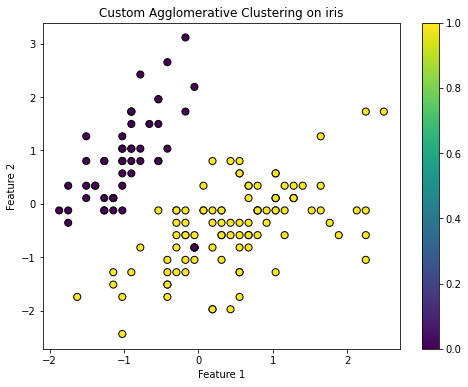

Sklearn Agglomerative Clustering Labels for iris: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


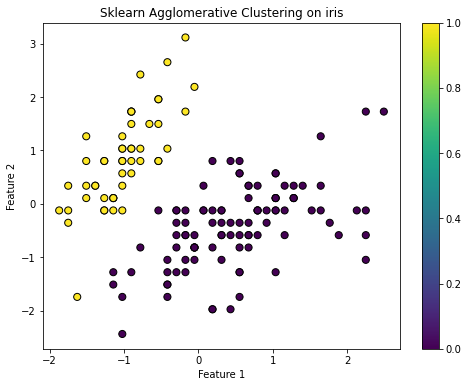


Metrics for iris:
Custom Agglomerative Metrics:
Adjusted Rand Index (ARI): 0.9464323886639676
Silhouette Score: 0.558164122034982
Davies-Bouldin Index: 0.6277342636151994
Calinski-Harabasz Index: 218.64763137110606
Homogeneity: 0.8900039242634512
Completeness: 0.8900039242634512
V-Measure: 0.8900039242634512
Number of Clusters: 2

Sklearn Agglomerative Metrics:
Adjusted Rand Index (ARI): 1.0
Silhouette Score: 0.580184463257396
Davies-Bouldin Index: 0.5975546650809878
Calinski-Harabasz Index: 248.90342786485118
Homogeneity: 1.0
Completeness: 1.0
V-Measure: 1.0
Number of Clusters: 2
Dataset: ai_global_index, Type: <class 'pandas.core.frame.DataFrame'>
Custom Agglomerative Clustering Labels for ai_global_index: [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


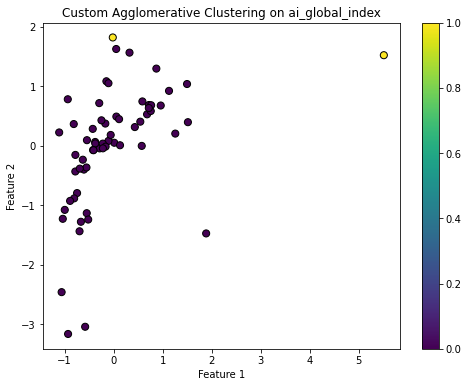

Sklearn Agglomerative Clustering Labels for ai_global_index: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


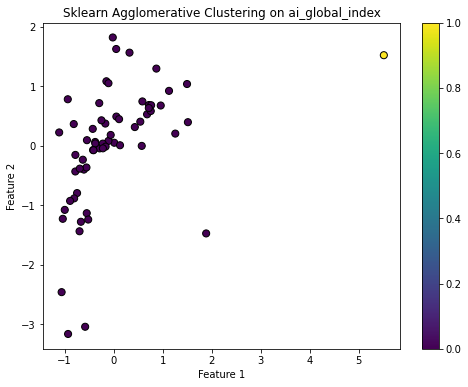


Metrics for ai_global_index:
Custom Agglomerative Metrics:
Adjusted Rand Index (ARI): 0.6479240364922734
Silhouette Score: 0.6780959283483551
Davies-Bouldin Index: 0.6378652246591447
Calinski-Harabasz Index: 30.088490936949945
Homogeneity: 0.7291878731870094
Completeness: 0.4224762998723958
V-Measure: 0.5349903240586071
Number of Clusters: 2

Sklearn Agglomerative Metrics:
Adjusted Rand Index (ARI): 1.0
Silhouette Score: 0.7358407911622495
Davies-Bouldin Index: 0.1730858956119127
Calinski-Harabasz Index: 25.94792255616781
Homogeneity: 1.0
Completeness: 1.0
V-Measure: 1.0
Number of Clusters: 2
Dataset: global_earthquake, Type: <class 'pandas.core.frame.DataFrame'>
Custom Agglomerative Clustering Labels for global_earthquake: [3 3 3 3 3 3 3 3 3 3 3 0 0 0 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0
 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 2 1 0 3 3 3 3 2 2 2]


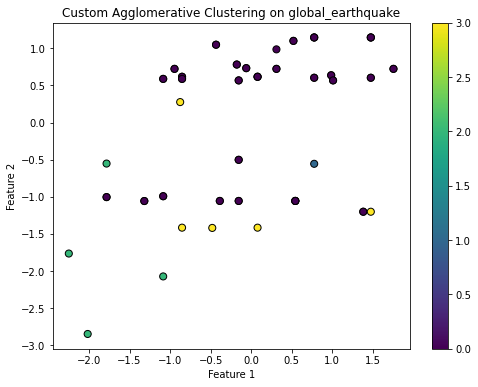

Sklearn Agglomerative Clustering Labels for global_earthquake: [1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 3 1 1 1 1 1 0 0 0]


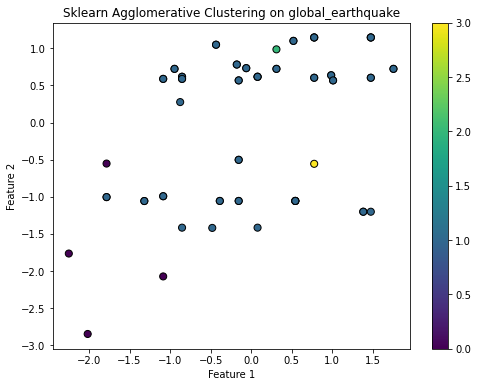


Metrics for global_earthquake:
Custom Agglomerative Metrics:
Adjusted Rand Index (ARI): 0.21018955702785674
Silhouette Score: -0.003395844377488791
Davies-Bouldin Index: 6.475043198667912
Calinski-Harabasz Index: 6.100581382495262
Homogeneity: 0.8267508783197015
Completeness: 0.3292713478548897
V-Measure: 0.47096910402037295
Number of Clusters: 4

Sklearn Agglomerative Metrics:
Adjusted Rand Index (ARI): 1.0
Silhouette Score: 0.3438511072918944
Davies-Bouldin Index: 0.7201294985212869
Calinski-Harabasz Index: 10.090403651819594
Homogeneity: 1.0
Completeness: 1.0
V-Measure: 1.0
Number of Clusters: 4


In [13]:
if __name__ == "__main__":
    # Load your datasets
    from sklearn.datasets import load_iris

    iris = load_iris()
    iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)

    # Define the best parameters for each dataset
    best_parameters = {
        'iris': {'n_clusters': 2, 'linkage': 'average'},
        'ai_global_index': {'n_clusters': 2, 'linkage': 'single'},
        'global_earthquake': {'n_clusters': 4, 'linkage': 'average'},
    }

    
    # Compare custom Agglomerative and Sklearn Agglomerative for all datasets
    results = compare_agglo_implementations(datasets, best_parameters)